## SETUP inicial
Aqui importamos as principais bibliotecas e definimos algumas configurações para a exploração dos dados. 
Vou utilizar um random state fixo de 42 para garantir a reprodutibilidade do modelo

### Objetivo
Desenvolver, treinar e avaliar modelos preditivos para estimar a probabilidade da variável target (y), utilizando os dados tratados no Notebook 2, respeitando a separação temporal e avaliando o desempenho por métricas adequadas ao problema de crédito.

In [19]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


Aqui vamos importar os dados do notebook 2 já pré-processados

In [20]:
# Treino
df_mediana = pd.read_csv('../data/processed/treino_mediana.csv')
df_media = pd.read_csv('../data/processed/treino_media.csv')
df_mediana_flag = pd.read_csv('../data/processed/treino_mediana_flag.csv')

# Validação
df_validacao_mediana = pd.read_csv('../data/processed/validacao_mediana.csv')
df_validacao_media = pd.read_csv('../data/processed/validacao_media.csv')
df_validacao_mediana_flag = pd.read_csv('../data/processed/validacao_mediana_flag.csv')

# Teste
df_teste_mediana = pd.read_csv('../data/processed/teste_mediana.csv')
df_teste_media = pd.read_csv('../data/processed/teste_media.csv')
df_teste_mediana_flag = pd.read_csv('../data/processed/teste_mediana_flag.csv')



Agora vamos definir algumas funções para separar as features da variavel target e para treinar o modelo e trazer as métricas.

In [21]:
def separa_xy(df):
    X = df.drop(columns=['id', 'safra', 'y'], errors='ignore')
    y = df['y']
    return X, y


In [22]:
def treinar_e_avaliar(X_train, y_train, X_valid, y_valid):
    model = LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        penalty='l2',  
        C=0.5         
    )
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    auc = roc_auc_score(y_valid, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    ks = max(tpr - fpr)
    gini = 2 * auc - 1
    
    return model, y_pred_proba, auc, ks, gini


In [23]:
pipelines = {
    'Mediana': (df_mediana, df_validacao_mediana, df_teste_mediana),
    'Média': (df_media, df_validacao_media, df_teste_media),
    'Mediana + Flag': (df_mediana_flag, df_validacao_mediana_flag, df_teste_mediana_flag)
}

resultados = []

for nome, (df_train, df_valid, df_test) in pipelines.items():
    X_train, y_train = separa_xy(df_train)
    X_valid, y_valid = separa_xy(df_valid)
    
    model, y_pred, auc, ks, gini = treinar_e_avaliar(X_train, y_train, X_valid, y_valid)
    
    resultados.append({
        'Pipeline': nome,
        'AUC': auc,
        'KS': ks,
        'Gini': gini,
        'Modelo': model,
        'y_pred': y_pred,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': separa_xy(df_test)[0],
        'y_test': separa_xy(df_test)[1]
    })

resultados_df = pd.DataFrame(resultados)
resultados_df[['Pipeline', 'AUC', 'KS', 'Gini']]


c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

,Pipeline,AUC,KS,Gini
0,Mediana,0.720107,0.321275,0.440213
1,Média,0.716277,0.323667,0.432553
2,Mediana + Flag,0.717879,0.327282,0.435758


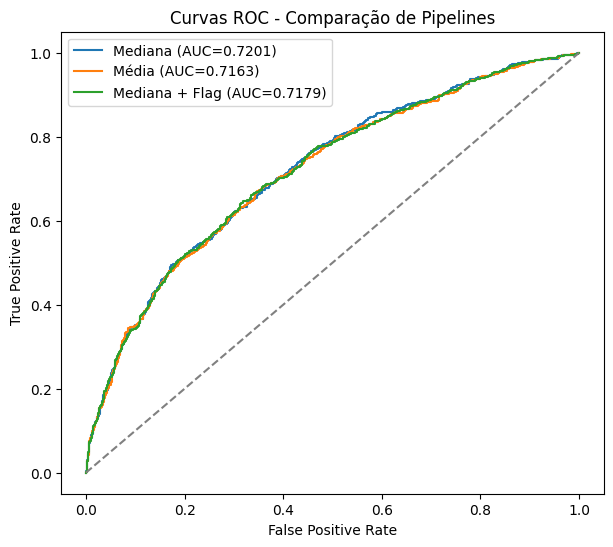

In [24]:
plt.figure(figsize=(7,6))

for i, row in resultados_df.iterrows():
    fpr, tpr, _ = roc_curve(separa_xy(pipelines[row['Pipeline']][1])[1], row['y_pred'])
    plt.plot(fpr, tpr, label=f"{row['Pipeline']} (AUC={row['AUC']:.4f})")

plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparação de Pipelines')
plt.legend()
plt.show()


In [25]:
melhor_idx = resultados_df['AUC'].idxmax()
melhor_pipeline = resultados_df.loc[melhor_idx, 'Pipeline']
melhor_modelo = resultados_df.loc[melhor_idx, 'Modelo']
X_train_best = resultados_df.loc[melhor_idx, 'X_train']
X_test_best = resultados_df.loc[melhor_idx, 'X_test']
y_test_best = resultados_df.loc[melhor_idx, 'y_test']

print(f"Melhor pipeline: {melhor_pipeline}")


Melhor pipeline: Mediana


In [26]:
y_test_pred = melhor_modelo.predict_proba(X_test_best)[:, 1]

auc_test = roc_auc_score(y_test_best, y_test_pred)
fpr_test, tpr_test, _ = roc_curve(y_test_best, y_test_pred)
ks_test = max(tpr_test - fpr_test)
gini_test = 2 * auc_test - 1

print(f"AUC (teste): {auc_test:.4f}")
print(f"KS (teste): {ks_test:.4f}")
print(f"Gini (teste): {gini_test:.4f}")


AUC (teste): 0.6455
KS (teste): 0.2175
Gini (teste): 0.2909


In [27]:
coef_df = pd.DataFrame({
    'Variável': X_train_best.columns,
    'Coeficiente': melhor_modelo.coef_[0]
}).sort_values('Coeficiente', key=abs, ascending=False)

coef_df.head(10)


,Variável,Coeficiente
10,VAR_4,-0.096671
14,VAR_2,-0.080692
2,VAR_25,-0.049549
8,VAR_57,-0.036667
15,VAR_3,-0.028087
0,VAR_1,0.020752
9,VAR_33,0.019009
4,VAR_19,0.011884
5,VAR_32,-0.011516
6,VAR_40,-0.008958
